In [4]:
import pandas as pd
import gzip
import json
import matplotlib.pyplot as plt
import os

# setup data path for two files

In [5]:
root = 'D:/study/computational_ds/project/data/'
# english file
gist_file = open(root+"nltk_data/corpora/stopwords/english", "r")
# dataset path
dataset_path = root + 'Software_5.json.gz'

# dataset overview

In [6]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [5]:
# for filename in os.listdir(root):
#   df = getDF(root + filename)
#   plt.hist(df['overall'])
#   plt.title('histgram of '+filename[:-8])
#   plt.show()


In [7]:
df = getDF(dataset_path)

In [8]:
df.head(2)

overall  verified   reviewTime      reviewerID        asin  \
0      4.0     False  10 20, 2010  A38NELQT98S4H8  0321719816   
1      4.0     False  10 18, 2010  A3QJU4FEN8PQSZ  0321719816   

                     style reviewerName  \
0  {'Format:': ' DVD-ROM'}    WB Halper   
1  {'Format:': ' DVD-ROM'}       Grimmy   

                                          reviewText  \
0  I've been using Dreamweaver (and it's predeces...   
1  The demo is done with the PC version, with ref...   

                               summary  unixReviewTime vote image  
0  A solid overview of Dreamweaver CS5      1287532800  NaN   NaN  
1                         A good value      1287360000  NaN   NaN

In [9]:
df = df[['overall','reviewText']]

(array([1500.,    0.,  719.,    0.,    0., 1598.,    0., 3016.,    0.,
        5972.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

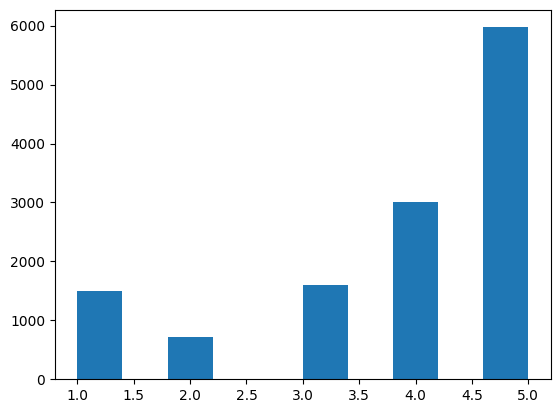

In [10]:
plt.hist(df['overall'])

## balance 5 levels

In [11]:
sample_size = df['overall'].value_counts().min()
groups = df.groupby('overall')
balance_idx = []
for key,subdf in groups:
    sample_idx = subdf.sample(n=sample_size).index
    balance_idx.extend(sample_idx)
balance_df = df.iloc[balance_idx]

In [12]:
balance_df.head(3)

overall                                         reviewText
4788       1.0  I have been involved with computers for 22 yea...
1677       1.0  Downloaded KIS7 because previous subscription ...
11224      1.0  Norton Security has been working fine for the ...

# data pre-preocess

## remove na and duplicate rows

In [13]:
balance_df.isna().sum()

overall       0
reviewText    0
dtype: int64

In [14]:
balance_df.dropna(inplace=True)

C:\Users\ZZY\AppData\Local\Temp\ipykernel_24016\4015747826.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balance_df.dropna(inplace=True)


In [15]:
balance_df.duplicated().sum()

262

In [16]:
balance_df.drop_duplicates(inplace=True)

C:\Users\ZZY\AppData\Local\Temp\ipykernel_24016\703317432.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balance_df.drop_duplicates(inplace=True)


## clean with nltk package

In [17]:
import nltk
import string
from nltk import pos_tag # Part-of-Speech (POS) tagging
from nltk.stem import WordNetLemmatizer # lemmatize a word
from nltk.stem.porter import PorterStemmer # Information Retrieval
from nltk.tokenize import word_tokenize # splits sentence into words 
from nltk.tokenize import WhitespaceTokenizer # splits on and discards only whitespace characters
from nltk.corpus import wordnet # large lexical database of English words
from nltk.sentiment.vader import SentimentIntensityAnalyzer # sentiment analyzer

# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('vader_lexicon')

In [18]:
# upload stopwords txt
content = gist_file.read()
stopwords = content.split("\n")
gist_file.close()

In [19]:
# return the wordnet object value
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    # remove \n
    text = text.replace('\n', '')
    # remove \t
    text = text.replace('\t', '')
    # remove ','
    text = text.replace(',', '')
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers and special characters 
    text = [word for word in text if word.isalnum() and not any(c.isdigit() for c in word)]
    # remove stop words
    text = [x for x in text if x not in stopwords]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = ' '.join(text)
    return(text)

In [24]:
balance_df['Clean_Review'] = balance_df['reviewText'].apply(lambda x: clean_text(x))
balance_df.head()

C:\Users\ZZY\AppData\Local\Temp\ipykernel_24016\291207919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balance_df['Clean_Review'] = balance_df['reviewText'].apply(lambda x: clean_text(x))


overall                                         reviewText  \
4788       1.0  I have been involved with computers for 22 yea...   
1677       1.0  Downloaded KIS7 because previous subscription ...   
11224      1.0  Norton Security has been working fine for the ...   
4261       1.0  same ol' same ol' from Microsoft - but what ca...   
6651       1.0  I have been using Quicken since the 2nd DOS ve...   

                                            Clean_Review  
4788   involve computer year expert design program co...  
1677   download previous subscription expire load say...  
11224  norton security work fine last year start use ...  
4261   ol ol microsoft expect company large dysfuncti...  
6651   use quicken since do version cannot understand...

In [25]:
len(balance_df)
balance_df.to_csv(root+'clean_sample_data.csv',index=False)